This notebook contains the data analysis for technical test as part of the selection process for DataSprints.
Let's import the necessary dependencies:

# Data Reading and Manipulation

## Setting up the dataframe

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from pandas.io.json import json_normalize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import gc
import requests
import os
%matplotlib inline

Verifying if the garbage collector is on. It finds the addresses in RAM which are not assigned to any variable, then freeing it up to the operational system and saving memory.

In [432]:
gc.isenabled()

True

Mounting google drive with data file:


In [433]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data = pd.read_json('/content/drive/My Drive/realties.json')

In [435]:
data.head()

,_id,_index,_score,_source,_type
2,LOr6iGcB_HRRL6pG3mnW,realties,1,"{'error': [], 'uf': 'PR', 'longitude': -49.278...",imovel
3,Ler6iGcB_HRRL6pG3mnb,realties,1,"{'error': [], 'uf': 'PR', 'longitude': -49.280...",imovel
7,5er7iGcB_HRRL6pG1Wn-,realties,1,"{'quarto': 3, 'error': [], 'uf': 'PR', 'longit...",imovel
8,5ur7iGcB_HRRL6pG1mkB,realties,1,"{'quarto': 4, 'error': [], 'uf': 'PR', 'longit...",imovel
9,3Or7iGcB_HRRL6pGxGl1,realties,1,{'anunciante': {'id': '411cbb1b8d58afa3b9419a1...,imovel


According to the orientation provided in the documentation PDF, the column ```source``` is the one containing information needed for the analysis. 

Verifying the columns of ```data```:

In [436]:
data['_source'].head()

2    {'error': [], 'uf': 'PR', 'longitude': -49.278...
3    {'error': [], 'uf': 'PR', 'longitude': -49.280...
7    {'quarto': 3, 'error': [], 'uf': 'PR', 'longit...
8    {'quarto': 4, 'error': [], 'uf': 'PR', 'longit...
9    {'anunciante': {'id': '411cbb1b8d58afa3b9419a1...
Name: _source, dtype: object

In [437]:
data['_index'].value_counts()

realties    149968
Name: _index, dtype: int64

In [438]:
data['_type'].value_counts()

imovel    149968
Name: _type, dtype: int64

In [439]:
data['_score'].value_counts()

1    149968
Name: _score, dtype: int64

All columns from ```data```, except for ```id``` and ```source```, have only one value, thus not being useful. ```id``` identifies each entry, therefore not being necessary either. 

Constructing a new dataframe from ```source```:

```json_normalize()``` unrolls the complex valued columns and places them in the same hierarchycal level in the dataframe:

In [0]:
source = json_normalize(data['_source'])

## Exploratory analysis by columns

Let's search for irrelevant columns in ```source```:

In [441]:
source.head()

,error,uf,longitude,url,condominio,cidade_uf,default,area_util,area_total,contato_imobiliaria,valor,isportal,isparticular,nome_corretor,banheiro,tipo_negocio,quarto,status,title,opcionais,latitude,descricao,lista_fotos,garagem,iptu,data_inclusao,codigo,finalidade,geohash,tipo_imovel,endereco,geometry.type,geometry.coordinates,scraping.spider_name,scraping.padrao,cidade.short_name,cidade.full_name,bairro.id,bairro.nome,zoneamento.id,zoneamento.sigla,zoneamento.nome,anunciante.id,anunciante.nome,area_construida,suite,area_terreno,area_privativa,cep,numero_corretor,idade_imovel,edificio,isconstrutora,area_comum,seguro_incendio,email_corretor,nome_contato,numero_contato_imagem,complemento,terreno_fundo,terreno_frente,terreno_esquerda,testada
0,[],PR,-49.278522,http://www.redebee.com.br/imovel/apartamento-r...,590.0,curitiba_pr,[finalidade],131.0,131.0,(41) 99165-0629,1590.0,False,False,Gomes Consultor Imobiliário,2.0,Locação,2.0,1,Apartamento de 131 m² na Rua Comendador Araújo...,"[{'location': ['imovel'], 'category': 'Serviço...",-25.435591,Prezado (a) Senhor (a). Muito obrigado por ent...,[https://imgbe.kenlo.com.br/VWRCUkQ2Tnp3d1BJRD...,1.0,77.0,2018-12-07 14:03:20,AP0145-GOMG,[Residencial],6gkzq9s6znnr,[Apartamento],"R. Comendador Araújo, 279",Point,"[-49.2785224915, -25.435590744]",redebee_curitiba_pr,in_gaia,Curitiba,"Curitiba, Paraná, Brasil",1679,Centro,GcJDsWQBpLEv0vTVF9WP,ZC,ZONA CENTRAL,411cbb1b8d58afa3b9419a19714844ae,Rede Bee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],PR,-49.280365,http://www.redebee.com.br/imovel/studio-reside...,356.0,curitiba_pr,[finalidade],36.0,69.0,(41) 99165-0629,1200.0,False,False,Gomes Consultor Imobiliário,1.0,Locação,1.0,1,"Studio de 36 m² na Rua Visconde de Nacar, 529 ...","[{'location': ['imovel'], 'category': 'Cômodo'...",-25.427486,Prezado (a) Senhor (a). Muito obrigado por ent...,[https://imgbe.kenlo.com.br/VWRCUkQ2Tnp3d1BJRD...,1.0,49.0,2018-12-07 14:03:20,ST0027-GOMG,[Residencial],6gkzqe54hkbx,[Studio],"Rua Visconde de Nácar, 544",Point,"[-49.2803649902, -25.4274864197]",redebee_curitiba_pr,in_gaia,Curitiba,"Curitiba, Paraná, Brasil",1687,Mercês,ZcJDsWQBpLEv0vTVF9WP,ZR-4,ZONA RESIDENCIAL 4,411cbb1b8d58afa3b9419a19714844ae,Rede Bee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[],PR,-49.349094,http://www.redebee.com.br/imovel/casa-residenc...,400.0,curitiba_pr,[finalidade],NaN,NaN,(41) 99165-0629,714200.0,False,False,Imobiliária Casteval,3.0,Venda,3.0,1,"Casa de 126 m² na Rua João Dembinski, 515 - Ca...","[{'location': ['imovel'], 'category': 'Seguran...",-25.453186,Essa é para você que além da Casa nova também ...,[https://imgbe.kenlo.com.br/VWRCUkQ2Tnp3d1BJRD...,1.0,NaN,2018-12-07 14:04:23,CA0072-CST,[Residencial],6gkzjn3h6y0p,[Casa],"R. João Dembinski, 472",Point,"[-49.3490943909, -25.4531860352]",redebee_curitiba_pr,in_gaia,Curitiba,"Curitiba, Paraná, Brasil",1686,Cidade Industrial,jcJDsWQBpLEv0vTVF9WP,ZR-2,ZONA RESIDENCIAL 2,411cbb1b8d58afa3b9419a19714844ae,Rede Bee,126.0,1.0,121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[],PR,-49.350033,http://www.redebee.com.br/imovel/casa-residenc...,620.0,curitiba_pr,[finalidade],NaN,NaN,(41) 99165-0629,1577800.0,False,False,Imobiliária Casteval,5.0,Venda,4.0,1,"Casa de 244 m² na Rua Carlos Benato, 640 - San...","[{'location': ['imovel'], 'category': 'Cômodo'...",-25.406399,Construção Impecavél e com excelente acabament...,[https://imgbe.kenlo.com.br/VWRCUkQ2Tnp3d1BJRD...,2.0,NaN,2018-12-07 14:04:24,CA0085-CST,[Residencial],6gkzmnbkuzur,[Casa],"R. Carlos Benato, 542",Point,"[-49.3500328064, -25.4063987732]",redebee_curitiba_pr,in_gaia,Curitiba,"Curitiba, Paraná, Brasil",1688,São Braz,JcJDsWQBpLEv0vTVF9WP,ZR-SF,ZONA RESIDENCIAL SANTA FELICIDADE,411cbb1b8d58afa3b9419a19714844ae,Rede Bee,244.0,2.0,526.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[],PR,-49.236857,http://www.redebee.com.br/imovel/loja-comercia...,NaN,curitiba_pr,[

In [442]:
source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149968 entries, 0 to 149967
Data columns (total 63 columns):
error                    149968 non-null object
uf                       149968 non-null object
longitude                119632 non-null float64
url                      149968 non-null object
condominio               109536 non-null float64
cidade_uf                149968 non-null object
default                  149968 non-null object
area_util                121362 non-null float64
area_total               106192 non-null float64
contato_imobiliaria      16729 non-null object
valor                    148506 non-null float64
isportal                 149968 non-null bool
isparticular             149968 non-null bool
nome_corretor            9584 non-null object
banheiro                 111725 non-null float64
tipo_negocio             149968 non-null object
quarto                   136878 non-null float64
status                   149968 non-null int64
title                    1

I am considering irrelevant the columns with less than 5% of non-null elements (< 7498 non-null objects)

In [0]:
source.drop(labels=['testada','terreno_esquerda','terreno_frente', 'terreno_fundo',
                    'complemento','email_corretor','seguro_incendio','isconstrutora',
                    'edificio','idade_imovel','numero_corretor'],axis=1,inplace=True)

Inspecting some particular columns:

In [444]:
source['opcionais'][0]

[{'category': 'Serviço', 'location': ['imovel'], 'name': 'TV a cabo'},
 {'category': 'Serviço',
  'location': ['imovel', 'edificio'],
  'name': 'Dependência de empregados'},
 {'category': 'Cômodo',
  'location': ['imovel', 'edificio'],
  'name': 'Sala de jantar'},
 {'category': 'Serviço', 'location': ['edificio'], 'name': 'Portaria'},
 {'category': 'Serviço',
  'location': ['imovel', 'edificio'],
  'name': 'Circuito de TV'},
 {'category': 'Serviço',
  'location': ['imovel', 'edificio'],
  'name': 'Interfone'},
 {'category': 'Serviço',
  'location': ['imovel', 'edificio'],
  'name': 'Elevador'},
 {'category': 'Serviço',
  'location': ['imovel', 'edificio'],
  'name': 'Portão Eletrônico'},
 {'category': 'Segurança',
  'location': ['edificio'],
  'name': 'Portaria 24 horas'},
 {'category': 'Cômodo', 'location': ['imovel'], 'name': 'Cozinha'},
 {'category': 'Acabamento', 'location': ['imovel'], 'name': 'Taco de madeira'}]

In [445]:
source['error']

0         []
1         []
2         []
3         []
4         []
          ..
149963    []
149964    []
149965    []
149966    []
149967    []
Name: error, Length: 149968, dtype: object

Verifying how many elements of ```error``` are nonempty:

In [446]:
# Checking how many elements of row "error" are nonempty
source[source['error'].apply(lambda x: x != list()) == True]['error']

9         [{'zoneamento': 'Zoneamento não identificado c...
90        [{'zoneamento': 'Zoneamento com mais de um ret...
91        [{'zoneamento': 'Zoneamento não identificado c...
98        [{'zoneamento': 'Zoneamento não identificado c...
175       [{'zoneamento': 'Zoneamento não identificado c...
                                ...                        
149897    [{'zoneamento': 'Zoneamento não identificado c...
149898    [{'zoneamento': 'Zoneamento não identificado c...
149911    [{'zoneamento': 'Zoneamento não identificado c...
149926    [{'zoneamento': 'Zoneamento não identificado c...
149927    [{'zoneamento': 'Zoneamento não identificado c...
Name: error, Length: 8924, dtype: object

In [447]:
source['error'].apply(len).value_counts()

0    141044
1      8657
2       261
3         6
Name: error, dtype: int64

In [448]:
source['error'].head(20)

0                                                    []
1                                                    []
2                                                    []
3                                                    []
4                                                    []
5                                                    []
6                                                    []
7                                                    []
8                                                    []
9     [{'zoneamento': 'Zoneamento não identificado c...
10                                                   []
11                                                   []
12                                                   []
13                                                   []
14                                                   []
15                                                   []
16                                                   []
17                                              

In [449]:
source['condominio']

0         590.0
1         356.0
2         400.0
3         620.0
4           NaN
          ...  
149963    630.0
149964    640.0
149965      0.0
149966    750.0
149967      0.0
Name: condominio, Length: 149968, dtype: float64

Plotting null elements for each column:


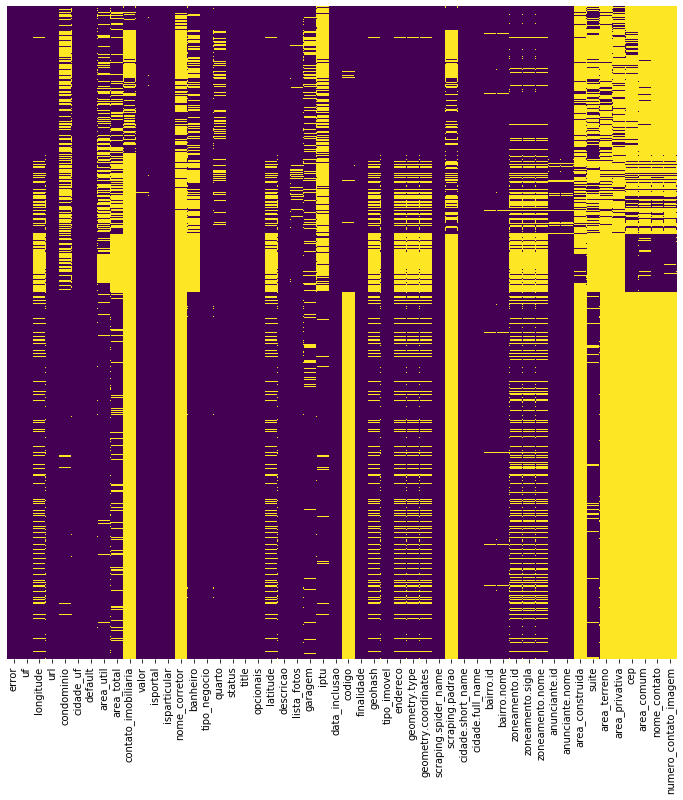

In [450]:
plt.figure(figsize=(12,12))
sns.heatmap(source.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [451]:
source['uf'].value_counts()

PR    149968
Name: uf, dtype: int64

In [452]:
source['cidade_uf'].value_counts()

curitiba_pr    149968
Name: cidade_uf, dtype: int64

In [453]:
source['contato_imobiliaria'].value_counts()

(41) 99165-0629       2723
(41) 3242-6565         968
 (41)9 9203-0057_      883
(41) 3239-6290         631
(41) 30927070          597
                      ... 
 (41) 99543-2504         7
(41) 3339-1990           6
 (41) 98835-2000         4
 (41) 99997-2312         4
 41988212050             3
Name: contato_imobiliaria, Length: 92, dtype: int64

In [454]:
source['isportal'].value_counts()

True     104948
False     45020
Name: isportal, dtype: int64

In [455]:
source['isparticular'].value_counts()

False    135390
True      14578
Name: isparticular, dtype: int64

In [456]:
source['default'].apply(len).value_counts()

1    117571
0     32397
Name: default, dtype: int64

In [461]:
source['nome_corretor'].value_counts()

Eliana                      315
Fernando Gomes              315
Imobiliária Time            257
José Luiz Bambulim          243
Vitória Imóveis Curitiba    237
                           ... 
Cristiane                     1
Maurivan                      1
Vilmar Kachuba                1
Wesley Bueno                  1
Marcia Elizabeti Favato       1
Name: nome_corretor, Length: 226, dtype: int64

In [462]:
source['banheiro'].value_counts()

1.0     39118
2.0     28741
3.0     16074
0.0      9699
4.0      9358
5.0      5480
6.0      2158
7.0       643
8.0       228
10.0       82
9.0        76
12.0       16
11.0       16
20.0        8
14.0        7
15.0        6
16.0        4
13.0        3
41.0        2
50.0        2
24.0        2
21.0        1
36.0        1
Name: banheiro, dtype: int64

In [463]:
source['quarto'].value_counts()

3.0     57619
2.0     33100
1.0     14487
0.0     14333
4.0     14094
5.0      2116
6.0       651
8.0       154
7.0       145
10.0       58
9.0        27
12.0       20
15.0       16
18.0       13
11.0       11
13.0        8
20.0        7
14.0        5
16.0        5
41.0        2
36.0        1
35.0        1
80.0        1
21.0        1
22.0        1
23.0        1
52.0        1
Name: quarto, dtype: int64

```banheiro``` and ```quarto``` seems to exhibit an interesting pattern:

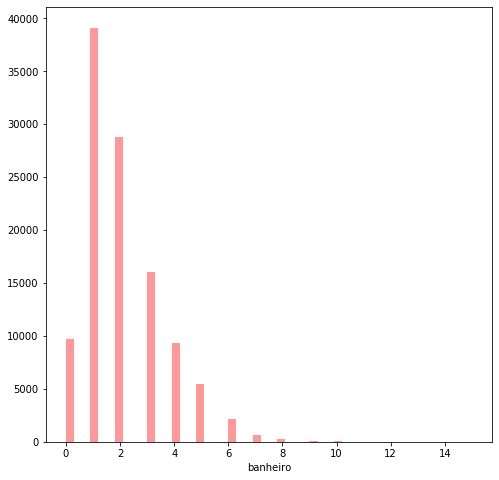

In [464]:
plt.figure(figsize=(8,8))
sns.distplot(source['banheiro'],bins=50,kde=False,color='r',hist_kws={"range":(0,15)})

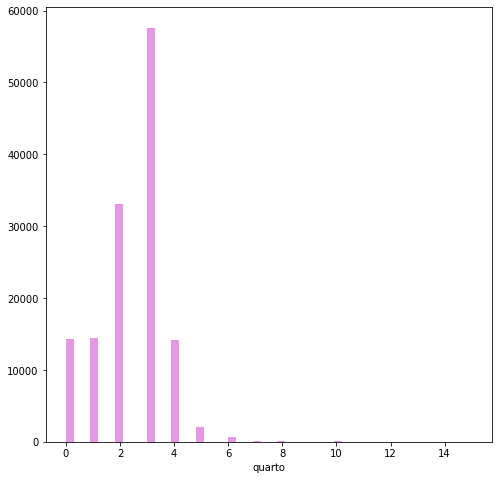

In [465]:
plt.figure(figsize=(8,8))
sns.distplot(source['quarto'],bins=50,kde=False,color='m',hist_kws={"range":(0,15)})

In [466]:
source['valor'].value_counts()

450000.0     1652
350000.0     1400
550000.0     1206
250000.0     1198
320000.0     1108
             ... 
248850.0        1
2502393.0       1
443900.0        1
1466470.0       1
1024.0          1
Name: valor, Length: 12038, dtype: int64

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


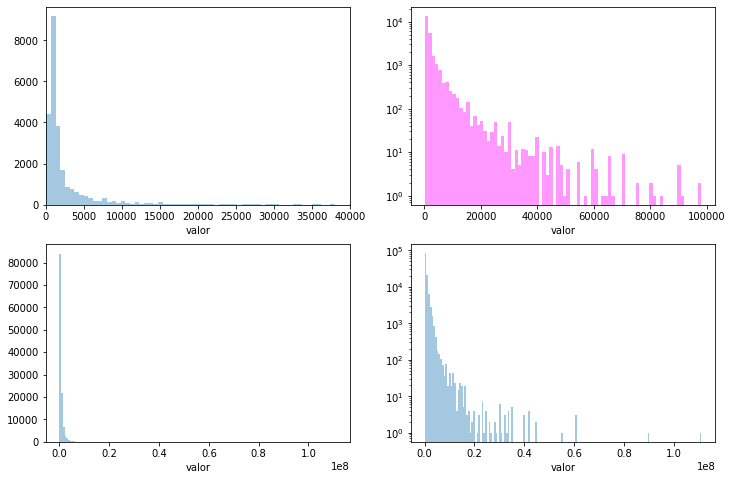

In [467]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.xlim(0,4*10**4)
ax = sns.distplot(a=essentials[locacoes]['valor'],kde=False,bins=int(np.sqrt(sum(locacoes))))
plt.subplot(2,2,2)
ax = sns.distplot(a=essentials[locacoes]['valor'],kde=False,bins=int(np.sqrt(sum(locacoes))/2),color='magenta')
ax.set_yscale('log')
plt.subplot(2,2,3)
ax = sns.distplot(a=essentials[vendas]['valor'],kde=False,bins=int(np.sqrt(sum(locacoes))))
plt.subplot(2,2,4)
ax = sns.distplot(a=essentials[vendas]['valor'],kde=False,bins=int(np.sqrt(sum(locacoes))))
ax.set_yscale('log')

In [468]:
source['tipo_negocio'].value_counts()

Venda      123582
Locação     26386
Name: tipo_negocio, dtype: int64

In [469]:
source['status'].value_counts()

1    149968
Name: status, dtype: int64

In [470]:
source['title'].value_counts()

Cibraco Imóveis: Lançamentos, Aluguel e Venda de imóveis e Terrenos                                    5113
Galvão                                                                                                 2931
Venda APARTAMENTO CURITIBA PR Brasil                                                                   2921
Baggio Imóveis – Soluções em negócios imobiliários                                                     1809
Venda Apartamento CURITIBA PR Brasil                                                                   1599
                                                                                                       ... 
LOJA BOM RETIRO                                                                                           1
Apartamento de 170m² de 3 dormitórios com vaga no Centro                                                  1
último lote disponível à venda, em condomínio de altíssimo padrão, em região nobre no cascatinha em       1
Casa 3 quartos à venda - Cap

In [471]:
source[source['anunciante.id']=='4804f11d42a20d0810d6032f4230f0e3']['title'].value_counts()

Casa em casa de condomínio 3 quartos à venda - Guabirotuba, Curitiba - PR 284779638 | OLX                             2
Casa 4 quartos à venda com Piscina - Seminário, Curitiba - PR 478800481 | OLX                                         2
Apartamento 3 quartos à venda - Mossunguê, Curitiba - PR 469411151 | OLX                                              2
Apartamento 3 quartos à venda com Área de serviço - Centro Cívico, Curitiba - PR 426653259 | OLX                      2
Apartamento 3 quartos à venda com Área de serviço - Alto da Glória, Curitiba - PR 445640240 | OLX                     2
                                                                                                                     ..
Apartamento 2 quartos à venda - Boqueirão, Curitiba - PR 555354802 | OLX                                              1
Casa em casa de condomínio 3 quartos à venda com Área de serviço - Santa Felicidade, Curitiba - PR 521425993 | OLX    1
Apartamento 1 quarto à venda com Área de

In [472]:
source['descricao'].value_counts()

In [473]:
source['status'].value_counts()

1    149968
Name: status, dtype: int64

In [474]:
source['codigo'].value_counts().head(25)
# This probably indicates duplicated data

02894.001    6
ANG 621      6
181119       5
06433.001    5
02912.001    4
02639.001    4
03153.001    4
02167.001    4
02575.001    4
01993.001    4
02367.001    4
02584.001    4
01833.001    4
02132.001    4
01169.001    4
02859.001    4
02544.001    4
181031       4
02142.001    4
02555.001    4
02004.001    4
02026.001    4
03134.001    4
01130.001    4
02882.001    4
Name: codigo, dtype: int64

In [475]:
source['descricao'].value_counts()

In [476]:
source['geohash'].value_counts()
# this information is probably related to the location of the properties

6gkzn13e5s7u    3606
6gkznwkvj5tr     525
6gkzqccdvdpx     468
6gkyys9snp52     404
6gkyvmphk87f     278
                ... 
6gkzxm5xq2e5       1
6gkyyjmcp8xq       1
6gkzq17ppnz7       1
6gkzn3rrnfqn       1
6gkzpzv9vbw9       1
Name: geohash, Length: 32579, dtype: int64

In [477]:
source['scraping.padrao'].value_counts()

in_gaia                    18861
i_value                     5124
webmarketingimobiliario     3721
unionsoftware                847
imobibrasil                  649
code49                       158
infocenter                    84
imoveloffice                  21
inovasite                      8
Name: scraping.padrao, dtype: int64

In [478]:
source['scraping.spider_name'].value_counts()

vivareal_curitiba                        84215
olx_regiao_de_curitiba_e_paranagua_pr    19816
cibracoimoveis_curitiba_pr                5113
portalimoveis_curitiba_pr                 3650
galvaolocacoes_curitiba_pr                2931
                                         ...  
galeede_pinhais_pr                           1
souzaecamargo_colombo_pr                     1
garcia_sao_jose_dos_pinhais_pr               1
grandelar_colombo_pr                         1
meular_campo_largo_pr                        1
Name: scraping.spider_name, Length: 203, dtype: int64

In [479]:
source['anunciante.nome'].value_counts()

Particular - OLX                                     14578
Cibraco                                               5113
WEGA IMÓVEIS                                          3650
Galvão Locações                                       2931
Rede Bee                                              2723
                                                     ...  
GOLDEN NEGOCIOS IMOBILIARIOS LTDA - ME - VivaReal        1
p h empreendimentos imobiliarios - OLX                   1
anderson.franco.corretor - OLX                           1
machado corretores imobiliários - OLX                    1
ALAMONT  ADM DE BENS - VivaReal                          1
Name: anunciante.nome, Length: 1582, dtype: int64

([<matplotlib.patches.Wedge at 0x7fe6dce1a240>,
  ...],
 [Text(1.0480154363499152, 0.33416110661221066, ''),
  Text(0.8229268678313741, 0.7299255922361158, ''),
  Text(0.6741486286466155, 0.8692086208119935, ''),
  Text(0.5468909035186462, 0.9544162297700931, ''),
  Text(0.4289940771974931, 1.0128988506901722, ''),
  Text(0.313651031445022, 1.0543353501014152, ''),
  Text(0.20195142406483146, 1.0813027431381956, ''),
  Text(0.10505379263936773, 1.0949720090724169, ''),
  Text(0.022159268265381945, 1.099776780455899, ''),
  Text(-0.05825682724772844, 1.0984562540579523, ''),
  Text(-0.13489499168162963, 1.091697458648326, ''),
  Text(-0.20803811190073013, 1.0801482046445199, ''),
  Text(-0.2779405947045109, 1.0643068287929487, ''),
  Text(-0.33592472237285703, 1.047451469471841, ''),
  Text(-0.38260921126070113, 1.031314787762914, ''),
  Text(-0.42684849722453383, 1.013804892677658, ''),
  Text(-0.46892023673805333, 0.995044627932601, ''),
  Text(-0.5092408704377961, 0.975024992436479, 

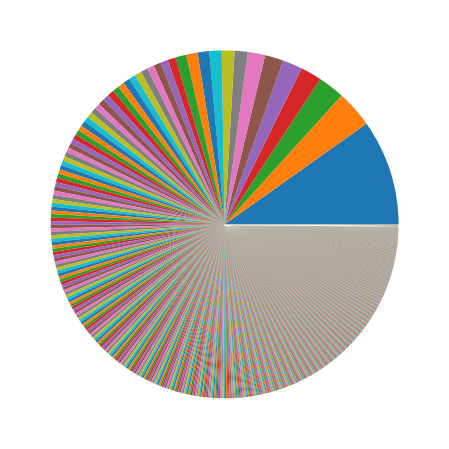

In [480]:
plt.figure(figsize=(8,8))
plt.pie(source['anunciante.nome'].value_counts())

Conclusions about the columns:

1.   Some columns, such as ```descricao``` and ```titulo``` only carry information about the ads, while others, such as ```quartos``` and ```banheiros``` contain relevant information about the properties. 

2.   Many columns, such as ```contato```, ```scraping.spider_name``` and ```url```, contain clumsy data that may not be very useful for the analysis. We will drop some of them later.  

3.   Many columns will not be useful for my analysis of the data. I will choose a small set of columns containing strings to be treated.   




# Duplicated data analysis

In [481]:
source['codigo'].value_counts()

02894.001     6
ANG 621       6
181119        5
06433.001     5
02912.001     4
             ..
145596        1
TE0023-ILB    1
4174          1
1159          1
557589655     1
Name: codigo, Length: 54317, dtype: int64

The column ```codigo``` seems to indicate data, as the number of repeated values is small, and it is supposed to have one value for one specific Ad.

## Verification of some cases

In [0]:
duplicated_test = source[(source['codigo']=='ANG 621') | (source['codigo']=='02894.001') | (source['codigo']=='06433.001')].copy()

In [483]:
duplicated_test.sort_values(by='codigo')

,error,uf,longitude,url,condominio,cidade_uf,default,area_util,area_total,contato_imobiliaria,valor,isportal,isparticular,nome_corretor,banheiro,tipo_negocio,quarto,status,title,opcionais,latitude,descricao,lista_fotos,garagem,iptu,data_inclusao,codigo,finalidade,geohash,tipo_imovel,endereco,geometry.type,geometry.coordinates,scraping.spider_name,scraping.padrao,cidade.short_name,cidade.full_name,bairro.id,bairro.nome,zoneamento.id,zoneamento.sigla,zoneamento.nome,anunciante.id,anunciante.nome,area_construida,suite,area_terreno,area_privativa,cep,area_comum,nome_contato,numero_contato_imagem
5905,[],PR,-49.253716,http://www.galvao.com.br/novosite/produto/id/4...,NaN,curitiba_pr,[finalidade],50.96,50.96,NaN,825.0,False,False,NaN,1.0,Locação,1.0,1,Galvão,"[{'location': ['imovel'], 'category': 'Eletrod...",-25.434221,"Quarto(s): 1, BWC Social: 1, \t\t\t \r\n\t\t\t...",[http://www.galvao.com.br/FotosRede/02894.001-...,NaN,NaN,2018-12-07 09:14:03,02894.001,[Residencial],6gkzr1ydcjx3,[Apartamento],"R. Atílio Bório, 139",Point,"[-49.253716, -25.434221]",galvaolocacoes_curitiba_pr,NaN,Curitiba,"Curitiba, Paraná, Brasil",1600,Cristo Rei,FsJDsWQBpLEv0vTVF9WP,SE,SETOR ESPECIAL ESTRUTURAL,f3907bc85c1244272532d88dd9fda4cf,Galvão Locações,NaN,NaN,NaN,NaN,80050250,NaN,NaN,NaN
24010,[],PR,-49.253628,http://www.cibraco.com.br/imovel.php?url=aluga...,NaN,curitiba_pr,[finalidade],31.59,50.96,NaN,937.0,False,False,NaN,NaN,Locação,NaN,1,"Cibraco Imóveis: Lançamentos, Aluguel e Venda ...","[{'location': ['imovel'], 'category': 'Eletrod...",-25.434225,Ótimo apartamento no Cristo ReiImovel contém 0...,[http://www.cibraco.com.br/images/imoveis/26/2...,1.0,NaN,2018-12-07 13:01:24,02894.001,[Residencial],6gkzr1ydgkc1,[Apartamento],"R. Atílio Bório, 139",Point,"[-49.25362778, -25.43422508]",cibracoimoveis_curitiba_pr,NaN,Curitiba,"Curitiba, Paraná, Brasil",1600,Cristo Rei,FsJDsWQBpLEv0vTVF9WP,SE,SETOR ESPECIAL ESTRUTURAL,4ee05a888fe5133580ef17993fd52ece,Cibraco,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13664,[],PR,-49.253750,http://www.cibraco.com.br/imovel.php?url=aluga...,NaN,curitiba_pr,[finalidade],150.00,150.00,NaN,1500.0,False,False,NaN,NaN,Locação,NaN,1,"Cibraco Imóveis: Lançamentos, Aluguel e Venda ...",[],-25.454536,Loja próxima da PUC; 2 portas de aço; Parede e...,[http://www.cibraco.com.br/images/imoveis/32/3...,NaN,NaN,2018-12-07 09:56:45,02894.001,[Comercial],6gkzpnns86qp,[Loja],"R. Iapó, 1536",Point,"[-49.25374985, -25.45453644]",cibracoimoveis_curitiba_pr,NaN,Curitiba,"Curitiba, Paraná, Brasil",1658,Prado Velho,j8JDsWQBpLEv0vTVF9WP,ZT-LV,ZONA DE TRANSIÇÃO DA LINHA VERDE,4ee05a888fe5133580ef17993fd52ece,Cibraco,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10325,[],PR,-49.280809,http://www.galvao.com.br/novosite/produto/id/4...,NaN,curitiba_pr,[finalidade],167.00,167.00,NaN,2145.0,False,False,NaN,1.0,Locação,3.0,1,Galvão,"[{'location': ['imovel'], 'category': 'Cômodo'...",-25.444161,"Quarto(s): 3, BWC Social: 1, BWC de Serviço: S...",[http://www.galvao.com.br/FotosRede/02894.001-...,NaN,NaN,2018-12-07 09:20:27,02894.001,[Residencial],6gkzq84c1bts,[Apartamento],"R. Cel. Dulcídio, 1256",Point,"[-49.2808087, -25.4441609]",galvaolocacoes_curitiba_pr,NaN,Curitiba,"Curitiba, Paraná, Brasil",1640,Água Verde,FsJDsWQBpLEv0vTVF9WP,SE,SETOR ESPECIAL ESTRUTURAL,f3907bc85c1244272532d88dd9fda4cf,Galvão Locações,NaN,NaN,NaN,NaN,80250100,NaN,NaN,NaN
15015,[],PR,-49.280808,http://www.cibraco.com.br/imovel.php?url=aluga...,NaN,curitiba_pr,[finalidade],127.00,167.00,NaN,1950.0,False,False,NaN,NaN,Locação,3.0,1,"Cibraco Imóveis: Lançamentos, Aluguel e Venda ...","[{'location': ['imovel'], 'category': 'Cômodo'...",-25.444160,A localização mais do que privilegiada no cent...,[http://www.cibraco.com.br/images/imoveis/51/5...,3.0,NaN,2018-12-07 10:07:43,02894.001,[Residencial],6gkzq84c1bww,[Apartamento],"R. Cel. Dulcídio, 1256",Point,"[-49.2808075, -25.44416046]",cibracoimoveis_curitiba_pr,NaN,Curitiba,"Curitiba, Paraná, Brasil",1640,Água Verde,FsJDsWQBpLEv0vTVF9WP,SE,SETOR ESPECIAL ESTR

It is possible to see that for ```codigo``` = ANG 621, three elements have the same information, such as same ```valor```, same ```area_util```, ```area_total```, etc. So ```codigo``` is useful for indicating duplicated data.

Fixing duplicated data using only columns that may be useful for identifying it

In [0]:
duplicated_test.drop(labels=['error','uf','condominio',
                      'cidade_uf','default','status','opcionais',
                      'iptu','finalidade','geometry.type',
                      'geometry.coordinates','descricao','contato_imobiliaria',
                      'nome_corretor','url','lista_fotos','geohash','data_inclusao',
                      'scraping.spider_name','cidade.short_name','cidade.full_name','bairro.id',
                      'bairro.nome','zoneamento.sigla','zoneamento.nome','scraping.padrao',
                      'zoneamento.id','title','tipo_imovel','endereco','cep','nome_contato'],axis=1,inplace=True)

Observations:

1. Latitude and Longitude do not always distinguish different data with same ```codigo```. It can happen for announcements made for one property with other small properties to be rent or sell. 
2. ```geohash``` seems to be different for different real estate agents, but the same whenever a real estate agent makes an announcement about a property in a specific location.
3. ```data_inclusao``` carries information about the moment the announcement was made
4. ```title``` is not very informative, as it should carry a small description of the Ad, but carries only the name of the real estate agent sometimes.
5. ```anunciante.nome``` and ```anunciante.id``` give the same information in two different ways

In [485]:
duplicated_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17 entries, 5905 to 31723
Data columns (total 20 columns):
longitude                17 non-null float64
area_util                17 non-null float64
area_total               17 non-null float64
valor                    17 non-null float64
isportal                 17 non-null bool
isparticular             17 non-null bool
banheiro                 6 non-null float64
tipo_negocio             17 non-null object
quarto                   8 non-null float64
latitude                 17 non-null float64
garagem                  5 non-null float64
codigo                   17 non-null object
anunciante.id            17 non-null object
anunciante.nome          17 non-null object
area_construida          0 non-null float64
suite                    0 non-null float64
area_terreno             0 non-null float64
area_privativa           0 non-null float64
area_comum               0 non-null float64
numero_contato_imagem    0 non-null object
dtypes: boo

Analysing how to deal with columns with datatype ```object```:

In [486]:
print(source['tipo_negocio'].value_counts(),
      '\n','\n',
      source['anunciante.id'].value_counts(), source['anunciante.nome'].value_counts(),
      '\n','\n',
      source['numero_contato_imagem'].value_counts())

Venda      123582
Locação     26386
Name: tipo_negocio, dtype: int64 
 
 4804f11d42a20d0810d6032f4230f0e3    14578
4ee05a888fe5133580ef17993fd52ece     5113
1cb77adc9886b9108ba741a9e53894cc     3650
f3907bc85c1244272532d88dd9fda4cf     2931
411cbb1b8d58afa3b9419a19714844ae     2723
                                    ...  
507e51f6ca521d6679fe66ea3ae8cb61        1
21fab705731b4970cbe8da4a7915fd0b        1
cfe1db4ac0965a8e768517f1c3988f62        1
20b55056ccfbdaed0aa4ffaca848c60c        1
1f81ba211f20e6a0ec9292b3116e7b73        1
Name: anunciante.id, Length: 1584, dtype: int64 Particular - OLX                                     14578
Cibraco                                               5113
WEGA IMÓVEIS                                          3650
Galvão Locações                                       2931
Rede Bee                                              2723
                                                     ...  
GOLDEN NEGOCIOS IMOBILIARIOS LTDA - ME - VivaReal        1
p h 

1.   ```tipo_negocio``` is a categoric data. Will be keeped.
2.   ```anunciante.nome``` will be keeped, while ```anunciante.id``` will be dropped.
3. ```numero_contato_imagem``` carries links with the contact number in an image format. We are not using this column.



In [0]:
duplicated_test.drop(labels=['anunciante.id','numero_contato_imagem'],axis=1,inplace=True)

In [488]:
duplicated_test

,longitude,area_util,area_total,valor,isportal,isparticular,banheiro,tipo_negocio,quarto,latitude,garagem,codigo,anunciante.nome,area_construida,suite,area_terreno,area_privativa,area_comum
5905,-49.253716,50.96,50.96,825.0,False,False,1.0,Locação,1.0,-25.434221,NaN,02894.001,Galvão Locações,NaN,NaN,NaN,NaN,NaN
7145,-49.295684,1247.00,1247.00,16500.0,False,False,2.0,Locação,NaN,-25.498756,NaN,ANG 621,Galvão Locações,NaN,NaN,NaN,NaN,NaN
7160,-49.312326,135.00,135.00,2420.0,False,False,1.0,Locação,3.0,-25.505674,NaN,06433.001,Galvão Locações,NaN,NaN,NaN,NaN,NaN
7220,-49.312424,132.60,132.60,1800.0,False,False,NaN,Locação,2.0,-25.441460,3.0,06433.001,Cibraco,NaN,NaN,NaN,NaN,NaN
7561,-49.253751,150.00,150.00,1650.0,False,False,2.0,Locação,NaN,-25.454536,NaN,02894.001,Galvão Locações,NaN,NaN,NaN,NaN,NaN
10325,-49.280809,167.00,167.00,2145.0,False,False,1.0,Locação,3.0,-25.444161,NaN,02894.001,Galvão Locações,NaN,NaN,NaN,NaN,NaN
10346,-49.312425,132.60,132.60,1980.0,False,False,1.0,Locação,3.0,-25.441459,NaN,06433.001,Galvão Locações,NaN,NaN,NaN,NaN,NaN
13664,-49.253750,150.00,150.00,1500.0,False,False,NaN,Locação,NaN,-25.454536,NaN,02894.001,Cibraco,NaN,NaN,NaN,NaN,NaN
15015,-49.280808,127.00,167.00,1950.0,False,False,NaN,Locação,3.0,-25.444160,3.0,02894.001,Cibraco,NaN,NaN,NaN,NaN,NaN
17145,-49.312458,135.00,135.00,2200.0,False,False,NaN,Locação,1.0,-25.505674,3.0,06433.001,Cibraco,NaN,NaN,NaN,NaN,NaN


In [0]:
duplicated_test.drop_duplicates(inplace=True)

In [490]:
duplicated_test['codigo'].value_counts()

02894.001    6
06433.001    4
ANG 621      4
Name: codigo, dtype: int64

Analyzing the new dataframe without duplicated data

In [491]:
duplicated_test[duplicated_test['codigo']=='02894.001']

,longitude,area_util,area_total,valor,isportal,isparticular,banheiro,tipo_negocio,quarto,latitude,garagem,codigo,anunciante.nome,area_construida,suite,area_terreno,area_privativa,area_comum
5905,-49.253716,50.96,50.96,825.0,False,False,1.0,Locação,1.0,-25.434221,NaN,02894.001,Galvão Locações,NaN,NaN,NaN,NaN,NaN
7561,-49.253751,150.00,150.00,1650.0,False,False,2.0,Locação,NaN,-25.454536,NaN,02894.001,Galvão Locações,NaN,NaN,NaN,NaN,NaN
10325,-49.280809,167.00,167.00,2145.0,False,False,1.0,Locação,3.0,-25.444161,NaN,02894.001,Galvão Locações,NaN,NaN,NaN,NaN,NaN
13664,-49.253750,150.00,150.00,1500.0,False,False,NaN,Locação,NaN,-25.454536,NaN,02894.001,Cibraco,NaN,NaN,NaN,NaN,NaN
15015,-49.280808,127.00,167.00,1950.0,False,False,NaN,Locação,3.0,-25.444160,3.0,02894.001,Cibraco,NaN,NaN,NaN,NaN,NaN
24010,-49.253628,31.59,50.96,937.0,False,False,NaN,Locação,NaN,-25.434225,1.0,02894.001,Cibraco,NaN,NaN,NaN,NaN,NaN


Once investigated how to treat duplicated data, we do the same for the whole data from source

## Removing duplicated data from whole dataframe

In [492]:
source.drop_duplicates(subset=['longitude', 'area_util', 'area_total', 'valor',
                               'isportal', 'isparticular', 'banheiro', 'tipo_negocio',
                               'quarto', 'latitude', 'garagem', 'codigo',
                               'anunciante.nome', 'area_construida', 'suite', 'area_terreno',
                               'area_privativa', 'area_comum'],inplace=True)
source.head(2)

,error,uf,longitude,url,condominio,cidade_uf,default,area_util,area_total,contato_imobiliaria,valor,isportal,isparticular,nome_corretor,banheiro,tipo_negocio,quarto,status,title,opcionais,latitude,descricao,lista_fotos,garagem,iptu,data_inclusao,codigo,finalidade,geohash,tipo_imovel,endereco,geometry.type,geometry.coordinates,scraping.spider_name,scraping.padrao,cidade.short_name,cidade.full_name,bairro.id,bairro.nome,zoneamento.id,zoneamento.sigla,zoneamento.nome,anunciante.id,anunciante.nome,area_construida,suite,area_terreno,area_privativa,cep,area_comum,nome_contato,numero_contato_imagem
0,[],PR,-49.278522,http://www.redebee.com.br/imovel/apartamento-r...,590.0,curitiba_pr,[finalidade],131.0,131.0,(41) 99165-0629,1590.0,False,False,Gomes Consultor Imobiliário,2.0,Locação,2.0,1,Apartamento de 131 m² na Rua Comendador Araújo...,"[{'location': ['imovel'], 'category': 'Serviço...",-25.435591,Prezado (a) Senhor (a). Muito obrigado por ent...,[https://imgbe.kenlo.com.br/VWRCUkQ2Tnp3d1BJRD...,1.0,77.0,2018-12-07 14:03:20,AP0145-GOMG,[Residencial],6gkzq9s6znnr,[Apartamento],"R. Comendador Araújo, 279",Point,"[-49.2785224915, -25.435590744]",redebee_curitiba_pr,in_gaia,Curitiba,"Curitiba, Paraná, Brasil",1679,Centro,GcJDsWQBpLEv0vTVF9WP,ZC,ZONA CENTRAL,411cbb1b8d58afa3b9419a19714844ae,Rede Bee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],PR,-49.280365,http://www.redebee.com.br/imovel/studio-reside...,356.0,curitiba_pr,[finalidade],36.0,69.0,(41) 99165-0629,1200.0,False,False,Gomes Consultor Imobiliário,1.0,Locação,1.0,1,"Studio de 36 m² na Rua Visconde de Nacar, 529 ...","[{'location': ['imovel'], 'category': 'Cômodo'...",-25.427486,Prezado (a) Senhor (a). Muito obrigado por ent...,[https://imgbe.kenlo.com.br/VWRCUkQ2Tnp3d1BJRD...,1.0,49.0,2018-12-07 14:03:20,ST0027-GOMG,[Residencial],6gkzqe54hkbx,[Studio],"Rua Visconde de Nácar, 544",Point,"[-49.2803649902, -25.4274864197]",redebee_curitiba_pr,in_gaia,Curitiba,"Curitiba, Paraná, Brasil",1687,Mercês,ZcJDsWQBpLEv0vTVF9WP,ZR-4,ZONA RESIDENCIAL 4,411cbb1b8d58afa3b9419a19714844ae,Rede Bee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Treatment of missing values

### Analysis of updated dataframe

Creating a dataframe with essential columns for providing data analysis

In [0]:
essentials = source.drop(labels=['error','uf','cidade_uf','default','status','opcionais',
                      'iptu','finalidade','geometry.type',
                      'geometry.coordinates','descricao','contato_imobiliaria',
                      'nome_corretor','url','lista_fotos','geohash','data_inclusao',
                      'scraping.spider_name','cidade.short_name','cidade.full_name','bairro.id',
                      'bairro.nome','zoneamento.sigla','zoneamento.nome','scraping.padrao',
                      'zoneamento.id','title','tipo_imovel','endereco','cep','nome_contato','anunciante.id','numero_contato_imagem'],axis=1)

In [494]:
essentials.head()

,longitude,condominio,area_util,area_total,valor,isportal,isparticular,banheiro,tipo_negocio,quarto,latitude,garagem,codigo,anunciante.nome,area_construida,suite,area_terreno,area_privativa,area_comum
0,-49.278522,590.0,131.0,131.0,1590.0,False,False,2.0,Locação,2.0,-25.435591,1.0,AP0145-GOMG,Rede Bee,NaN,NaN,NaN,NaN,NaN
1,-49.280365,356.0,36.0,69.0,1200.0,False,False,1.0,Locação,1.0,-25.427486,1.0,ST0027-GOMG,Rede Bee,NaN,NaN,NaN,NaN,NaN
2,-49.349094,400.0,NaN,NaN,714200.0,False,False,3.0,Venda,3.0,-25.453186,1.0,CA0072-CST,Rede Bee,126.0,1.0,121.0,NaN,NaN
3,-49.350033,620.0,NaN,NaN,1577800.0,False,False,5.0,Venda,4.0,-25.406399,2.0,CA0085-CST,Rede Bee,244.0,2.0,526.0,NaN,NaN
4,-49.236857,NaN,23.0,23.0,650.0,False,False,1.0,Locação,NaN,-25.503107,NaN,LO0027-OTI,Rede Bee,NaN,NaN,NaN,NaN,NaN


In [495]:
essentials.describe()

,longitude,condominio,area_util,area_total,valor,banheiro,quarto,latitude,garagem,area_construida,suite,area_terreno,area_privativa,area_comum
count,115196.000000,1.047510e+05,1.165020e+05,1.018390e+05,1.434910e+05,106934.000000,132010.000000,115196.000000,124170.000000,14804.000000,91162.000000,9.368000e+03,11393.000000,18978.000000
mean,-49.283416,2.777700e+03,4.641345e+02,2.234051e+03,6.125984e+05,2.061103,2.407477,-25.453971,1.879786,215.178288,0.978445,1.913267e+03,192.896780,139.249063
std,1.076287,2.909510e+05,4.080425e+04,4.482594e+05,1.189036e+06,1.544567,1.314865,1.202890,3.396570,513.985873,1.059804,9.474090e+04,793.932391,429.234915
min,-100.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+02,0.000000,0.000000,-100.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,-49.299569,0.000000e+00,5.600000e+01,7.600000e+01,1.780000e+05,1.000000,2.000000,-25.475141,1.000000,94.000000,0.000000,1.350000e+02,57.000000,57.000000
50%,-49.279695,2.000000e+02,8.800000e+01,1.320000e+02,3.650000e+05,2.000000,3.000000,-25.442023,1.000000,145.000000,1.000000,2.805000e+02,91.000000,88.000000
75%,-49.255963,4.500000e+02,1.623600e+02,2.547400e+02,6.900000e+05,3.000000,3.000000,-25.423386,2.000000,230.000000,1.000000,5.260000e+02,173.000000,150.000000
max,49.313489,6.458362e+07,7.774000e+06,1.418189e+08,1.111111e+08,50.000000,80.000000,27.664827,600.000000,23905.000000,41.000000,8.820000e+06,42545.000000,18108.000000


In [496]:
essentials.corr()

,longitude,condominio,area_util,area_total,valor,isportal,isparticular,banheiro,quarto,latitude,garagem,area_construida,suite,area_terreno,area_privativa,area_comum
longitude,1.000000,-0.000704,0.000241,0.000212,-0.005349,0.016733,0.033687,0.004225,-0.003078,0.820143,-0.000989,-0.001628,-0.018051,0.002641,-0.005217,0.000913
condominio,-0.000704,1.000000,-0.000083,-0.000046,-0.000145,-0.014414,-0.000341,0.011936,0.002710,0.000052,-0.000467,-0.006874,0.016260,-0.003302,0.000544,0.007768
area_util,0.000241,-0.000083,1.000000,0.997288,0.093668,-0.003306,-0.002349,-0.008805,-0.012578,-0.000041,-0.000773,0.110106,-0.006019,0.642161,0.617275,0.998158
area_total,0.000212,-0.000046,0.997288,1.000000,0.008035,0.002119,NaN,-0.005103,-0.006848,-0.000234,-0.000763,0.927667,-0.003868,0.999192,0.489458,0.075920
valor,-0.005349,-0.000145,0.093668,0.008035,1.000000,0.010804,-0.040379,0.372768,0.189848,0.000613,0.257542,0.335113,0.382107,0.018427,0.332258,0.100834
isportal,0.016733,-0.014414,-0.003306,0.002119,0.010804,1.000000,0.223544,-0.048360,-0.088009,0.011052,-0.049741,-0.053246,-0.161483,0.033495,NaN,0.039312
isparticular,0.033687,-0.000341,-0.002349,NaN,-0.040379,0.223544,1.000000,NaN,0.042406,0.016820,-0.014665,-0.032757,NaN,NaN,NaN,0.008164
banheiro,0.004225,0.011936,-0.008805,-0.005103,0.372768,-0.048360,NaN,1.000000,0.594839,0.015678,0.367908,0.389415,0.729543,0.078922,0.154717,0.631564
quarto,-0.003078,0.002710,-0.012578,-0.006848,0.189848,-0.088009,0.042406,0.594839,1.000000,-0.000503,0.205015,0.115208,0.604670,0.063169,0.097829,0.148812
latitude,0.820143,0.000052,-0.000041,-0.000234,0.000613,0.011052,0.016820,0.015678,-0.000503,1.000000,0.002499,-0.003908,0.021402,0.000024,0.001319,-0.000446


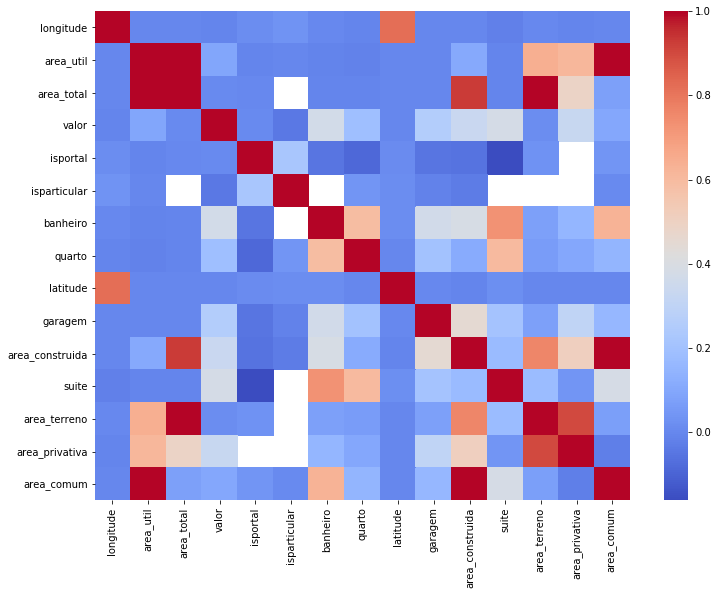

In [497]:
plt.figure(figsize=(12,9))
sns.heatmap(essentials.drop(labels='condominio',axis=1).corr(),cmap='coolwarm')

In [498]:
essentials.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144939 entries, 0 to 149967
Data columns (total 19 columns):
longitude          115196 non-null float64
condominio         104751 non-null float64
area_util          116502 non-null float64
area_total         101839 non-null float64
valor              143491 non-null float64
isportal           144939 non-null bool
isparticular       144939 non-null bool
banheiro           106934 non-null float64
tipo_negocio       144939 non-null object
quarto             132010 non-null float64
latitude           115196 non-null float64
garagem            124170 non-null float64
codigo             64890 non-null object
anunciante.nome    143430 non-null object
area_construida    14804 non-null float64
suite              91162 non-null float64
area_terreno       9368 non-null float64
area_privativa     11393 non-null float64
area_comum         18978 non-null float64
dtypes: bool(2), float64(14), object(3)
memory usage: 20.2+ MB


In [0]:
locacoes =  essentials['tipo_negocio']=='Locação'
vendas =  essentials['tipo_negocio']=='Venda'

In [0]:
datasize = len(essentials)

In [501]:
essentials['longitude'].apply(np.isnan).sum()

29743

In [502]:
essentials['isportal'].apply(np.isnan).sum()

0

In [503]:
essentials['tipo_negocio'].unique()

array(['Locação', 'Venda'], dtype=object)

In [504]:
essentials.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144939 entries, 0 to 149967
Data columns (total 19 columns):
longitude          115196 non-null float64
condominio         104751 non-null float64
area_util          116502 non-null float64
area_total         101839 non-null float64
valor              143491 non-null float64
isportal           144939 non-null bool
isparticular       144939 non-null bool
banheiro           106934 non-null float64
tipo_negocio       144939 non-null object
quarto             132010 non-null float64
latitude           115196 non-null float64
garagem            124170 non-null float64
codigo             64890 non-null object
anunciante.nome    143430 non-null object
area_construida    14804 non-null float64
suite              91162 non-null float64
area_terreno       9368 non-null float64
area_privativa     11393 non-null float64
area_comum         18978 non-null float64
dtypes: bool(2), float64(14), object(3)
memory usage: 20.2+ MB


## Dataframe for missing values

Creating dataframe of booleans for identifying NaNs

In [0]:
nan_elements = essentials.drop(labels=['tipo_negocio','codigo','anunciante.nome'],axis=1).apply(np.isnan)

In [506]:
nan_elements.head()

,longitude,condominio,area_util,area_total,valor,isportal,isparticular,banheiro,quarto,latitude,garagem,area_construida,suite,area_terreno,area_privativa,area_comum
0,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True
1,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True
2,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,True
3,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,True
4,False,True,False,False,False,False,False,False,True,False,True,True,True,True,True,True


In [507]:
np.sum(nan_elements)

longitude           29743
condominio          40188
area_util           28437
area_total          43100
valor                1448
isportal                0
isparticular            0
banheiro            38005
quarto              12929
latitude            29743
garagem             20769
area_construida    130135
suite               53777
area_terreno       135571
area_privativa     133546
area_comum         125961
dtype: int64

Evaluating rate of NaNs in each column:

In [508]:
nan_rate = np.sum(nan_elements)/datasize
nan_rate

longitude          0.205210
condominio         0.277275
area_util          0.196200
area_total         0.297366
valor              0.009990
isportal           0.000000
isparticular       0.000000
banheiro           0.262214
quarto             0.089203
latitude           0.205210
garagem            0.143295
area_construida    0.897860
suite              0.371032
area_terreno       0.935366
area_privativa     0.921395
area_comum         0.869062
dtype: float64

In [509]:
np.median(nan_rate)

0.2337121133718323

In [510]:
nan_rate>0.5

longitude          False
condominio         False
area_util          False
area_total         False
valor              False
isportal           False
isparticular       False
banheiro           False
quarto             False
latitude           False
garagem            False
area_construida     True
suite              False
area_terreno        True
area_privativa      True
area_comum          True
dtype: bool

Eliminating other unnecessary columns:

In [0]:
essentials.drop(labels=['area_construida','area_terreno','area_privativa','area_comum'],axis=1,inplace=True)
nan_elements.drop(labels=['area_construida','area_terreno','area_privativa','area_comum'],axis=1,inplace=True)

In [0]:
emptycolsrate = list()
for i in range(15):
  emptycolsrate.append(sum(np.sum(nan_elements,axis=1)==i)/datasize)

The following graph shows number of NaN elements per number of columns 

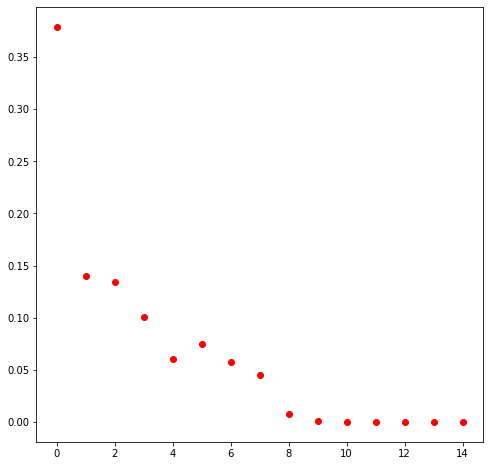

In [513]:
plt.figure(figsize=(8,8))
plt.plot(range(15),emptycolsrate,'ro')

I choose to eliminate every data with ```valor``` empty 

In [514]:
emptyvaluesidx = essentials[essentials['valor'].apply(np.isnan)==True].index
emptyvaluesidx

Int64Index([ 1082,  2674,  2844,  3530,  3634,  3742,  3744,  3860,  4541,
             4892,
            ...
            52469, 52474, 52660, 52666, 53049, 53246, 54442, 63647, 64230,
            65192],
           dtype='int64', length=1448)

In [0]:
essentials.drop(index=emptyvaluesidx,inplace=True)

In [516]:
nan_elements = essentials.drop(labels=['tipo_negocio','codigo','anunciante.nome'],axis=1).apply(np.isnan)
np.sum(nan_elements)

longitude       29454
condominio      38814
area_util       27961
area_total      42759
valor               0
isportal            0
isparticular        0
banheiro        37013
quarto          12656
latitude        29454
garagem         20101
suite           52740
dtype: int64

In [517]:
nan_elements.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143491 entries, 0 to 149967
Data columns (total 12 columns):
longitude       143491 non-null bool
condominio      143491 non-null bool
area_util       143491 non-null bool
area_total      143491 non-null bool
valor           143491 non-null bool
isportal        143491 non-null bool
isparticular    143491 non-null bool
banheiro        143491 non-null bool
quarto          143491 non-null bool
latitude        143491 non-null bool
garagem         143491 non-null bool
suite           143491 non-null bool
dtypes: bool(12)
memory usage: 2.7 MB


In [518]:
nan_rate = np.sum(nan_elements)/datasize
nan_rate

longitude       0.203217
condominio      0.267795
area_util       0.192916
area_total      0.295014
valor           0.000000
isportal        0.000000
isparticular    0.000000
banheiro        0.255370
quarto          0.087319
latitude        0.203217
garagem         0.138686
suite           0.363877
dtype: float64

New dataframe without columns of datatype object

In [0]:
nonobj_essentials = essentials.drop(columns=['anunciante.nome','codigo','tipo_negocio'])

In [520]:
nonobj_essentials.head()

,longitude,condominio,area_util,area_total,valor,isportal,isparticular,banheiro,quarto,latitude,garagem,suite
0,-49.278522,590.0,131.0,131.0,1590.0,False,False,2.0,2.0,-25.435591,1.0,NaN
1,-49.280365,356.0,36.0,69.0,1200.0,False,False,1.0,1.0,-25.427486,1.0,NaN
2,-49.349094,400.0,NaN,NaN,714200.0,False,False,3.0,3.0,-25.453186,1.0,1.0
3,-49.350033,620.0,NaN,NaN,1577800.0,False,False,5.0,4.0,-25.406399,2.0,2.0
4,-49.236857,NaN,23.0,23.0,650.0,False,False,1.0,NaN,-25.503107,NaN,NaN


## Replacing NaNs

It is necessary to replace NaNs for some other value instead of eliminating the corresponding data. To minimize the effect over the variances, I replace them by the average of the column. This will not artificially increase the std deviation, thus not hindering the Principal Component Analysis.

In [0]:
for col in nonobj_essentials.columns.values:
  nonobj_essentials[col].fillna(value=nonobj_essentials[col].mean(),inplace=True)

In [522]:
nonobj_essentials.head(10)

,longitude,condominio,area_util,area_total,valor,isportal,isparticular,banheiro,quarto,latitude,garagem,suite
0,-49.278522,590.000000,131.000000,131.000000,1590.0,False,False,2.00000,2.000000,-25.435591,1.000000,0.976904
1,-49.280365,356.000000,36.000000,69.000000,1200.0,False,False,1.00000,1.000000,-25.427486,1.000000,0.976904
2,-49.349094,400.000000,467.048829,2256.762395,714200.0,False,False,3.00000,3.000000,-25.453186,1.000000,1.000000
3,-49.350033,620.000000,467.048829,2256.762395,1577800.0,False,False,5.00000,4.000000,-25.406399,2.000000,2.000000
4,-49.236857,2777.111603,23.000000,23.000000,650.0,False,False,1.00000,2.407888,-25.503107,1.882187,0.976904
5,-49.355035,2777.111603,467.048829,2256.762395,1200000.0,False,False,4.00000,3.000000,-25.389416,4.000000,1.000000
6,-49.241561,2777.111603,467.048829,206.000000,870000.0,False,False,4.00000,3.000000,-25.426355,2.000000,1.000000
7,-49.296065,2777.111603,467.048829,2256.762395,1800.0,False,False,1.00000,3.000000,-25.504267,2.000000,1.000000
8,-49.277923,380.000000,59.000000,104.000000,260000.0,False,False,1.00000,3.000000,-25.453071,1.000000,1.000000
9,-49.296844,80.000000,35.000000,2256.762395,800.0,False,False,2.05943,2.407888,-25.391611,1.882187,0.976904


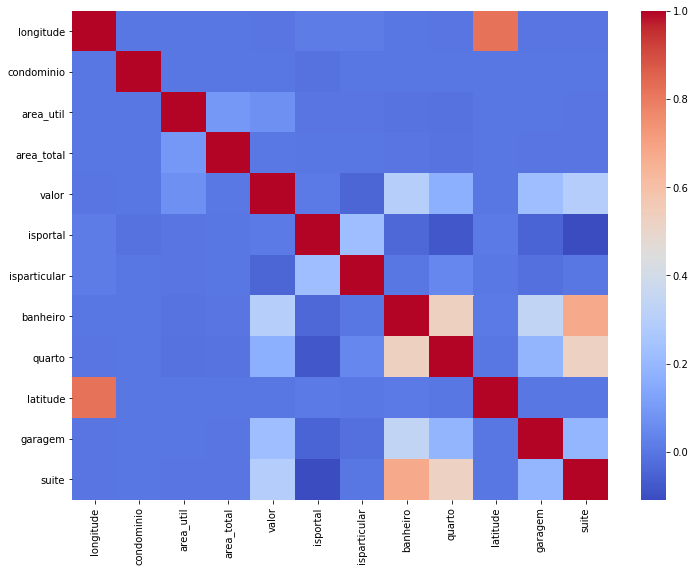

In [523]:
plt.figure(figsize=(12,9))
sns.heatmap(nonobj_essentials.corr(),cmap='coolwarm')

In [524]:
essentials.head()

,longitude,condominio,area_util,area_total,valor,isportal,isparticular,banheiro,tipo_negocio,quarto,latitude,garagem,codigo,anunciante.nome,suite
0,-49.278522,590.0,131.0,131.0,1590.0,False,False,2.0,Locação,2.0,-25.435591,1.0,AP0145-GOMG,Rede Bee,NaN
1,-49.280365,356.0,36.0,69.0,1200.0,False,False,1.0,Locação,1.0,-25.427486,1.0,ST0027-GOMG,Rede Bee,NaN
2,-49.349094,400.0,NaN,NaN,714200.0,False,False,3.0,Venda,3.0,-25.453186,1.0,CA0072-CST,Rede Bee,1.0
3,-49.350033,620.0,NaN,NaN,1577800.0,False,False,5.0,Venda,4.0,-25.406399,2.0,CA0085-CST,Rede Bee,2.0
4,-49.236857,NaN,23.0,23.0,650.0,False,False,1.0,Locação,NaN,-25.503107,NaN,LO0027-OTI,Rede Bee,NaN


Replacing Nans in dataframe ```essentials```

In [0]:
for col in set(essentials.columns.values).difference(set(['tipo_negocio','codigo','anunciante.nome'])):
  essentials[col].fillna(value=nonobj_essentials[col].mean(),inplace=True)

In [526]:
essentials.head()

,longitude,condominio,area_util,area_total,valor,isportal,isparticular,banheiro,tipo_negocio,quarto,latitude,garagem,codigo,anunciante.nome,suite
0,-49.278522,590.000000,131.000000,131.000000,1590.0,False,False,2.0,Locação,2.000000,-25.435591,1.000000,AP0145-GOMG,Rede Bee,0.976904
1,-49.280365,356.000000,36.000000,69.000000,1200.0,False,False,1.0,Locação,1.000000,-25.427486,1.000000,ST0027-GOMG,Rede Bee,0.976904
2,-49.349094,400.000000,467.048829,2256.762395,714200.0,False,False,3.0,Venda,3.000000,-25.453186,1.000000,CA0072-CST,Rede Bee,1.000000
3,-49.350033,620.000000,467.048829,2256.762395,1577800.0,False,False,5.0,Venda,4.000000,-25.406399,2.000000,CA0085-CST,Rede Bee,2.000000
4,-49.236857,2777.111603,23.000000,23.000000,650.0,False,False,1.0,Locação,2.407888,-25.503107,1.882187,LO0027-OTI,Rede Bee,0.976904


<Figure size 864x864 with 0 Axes>

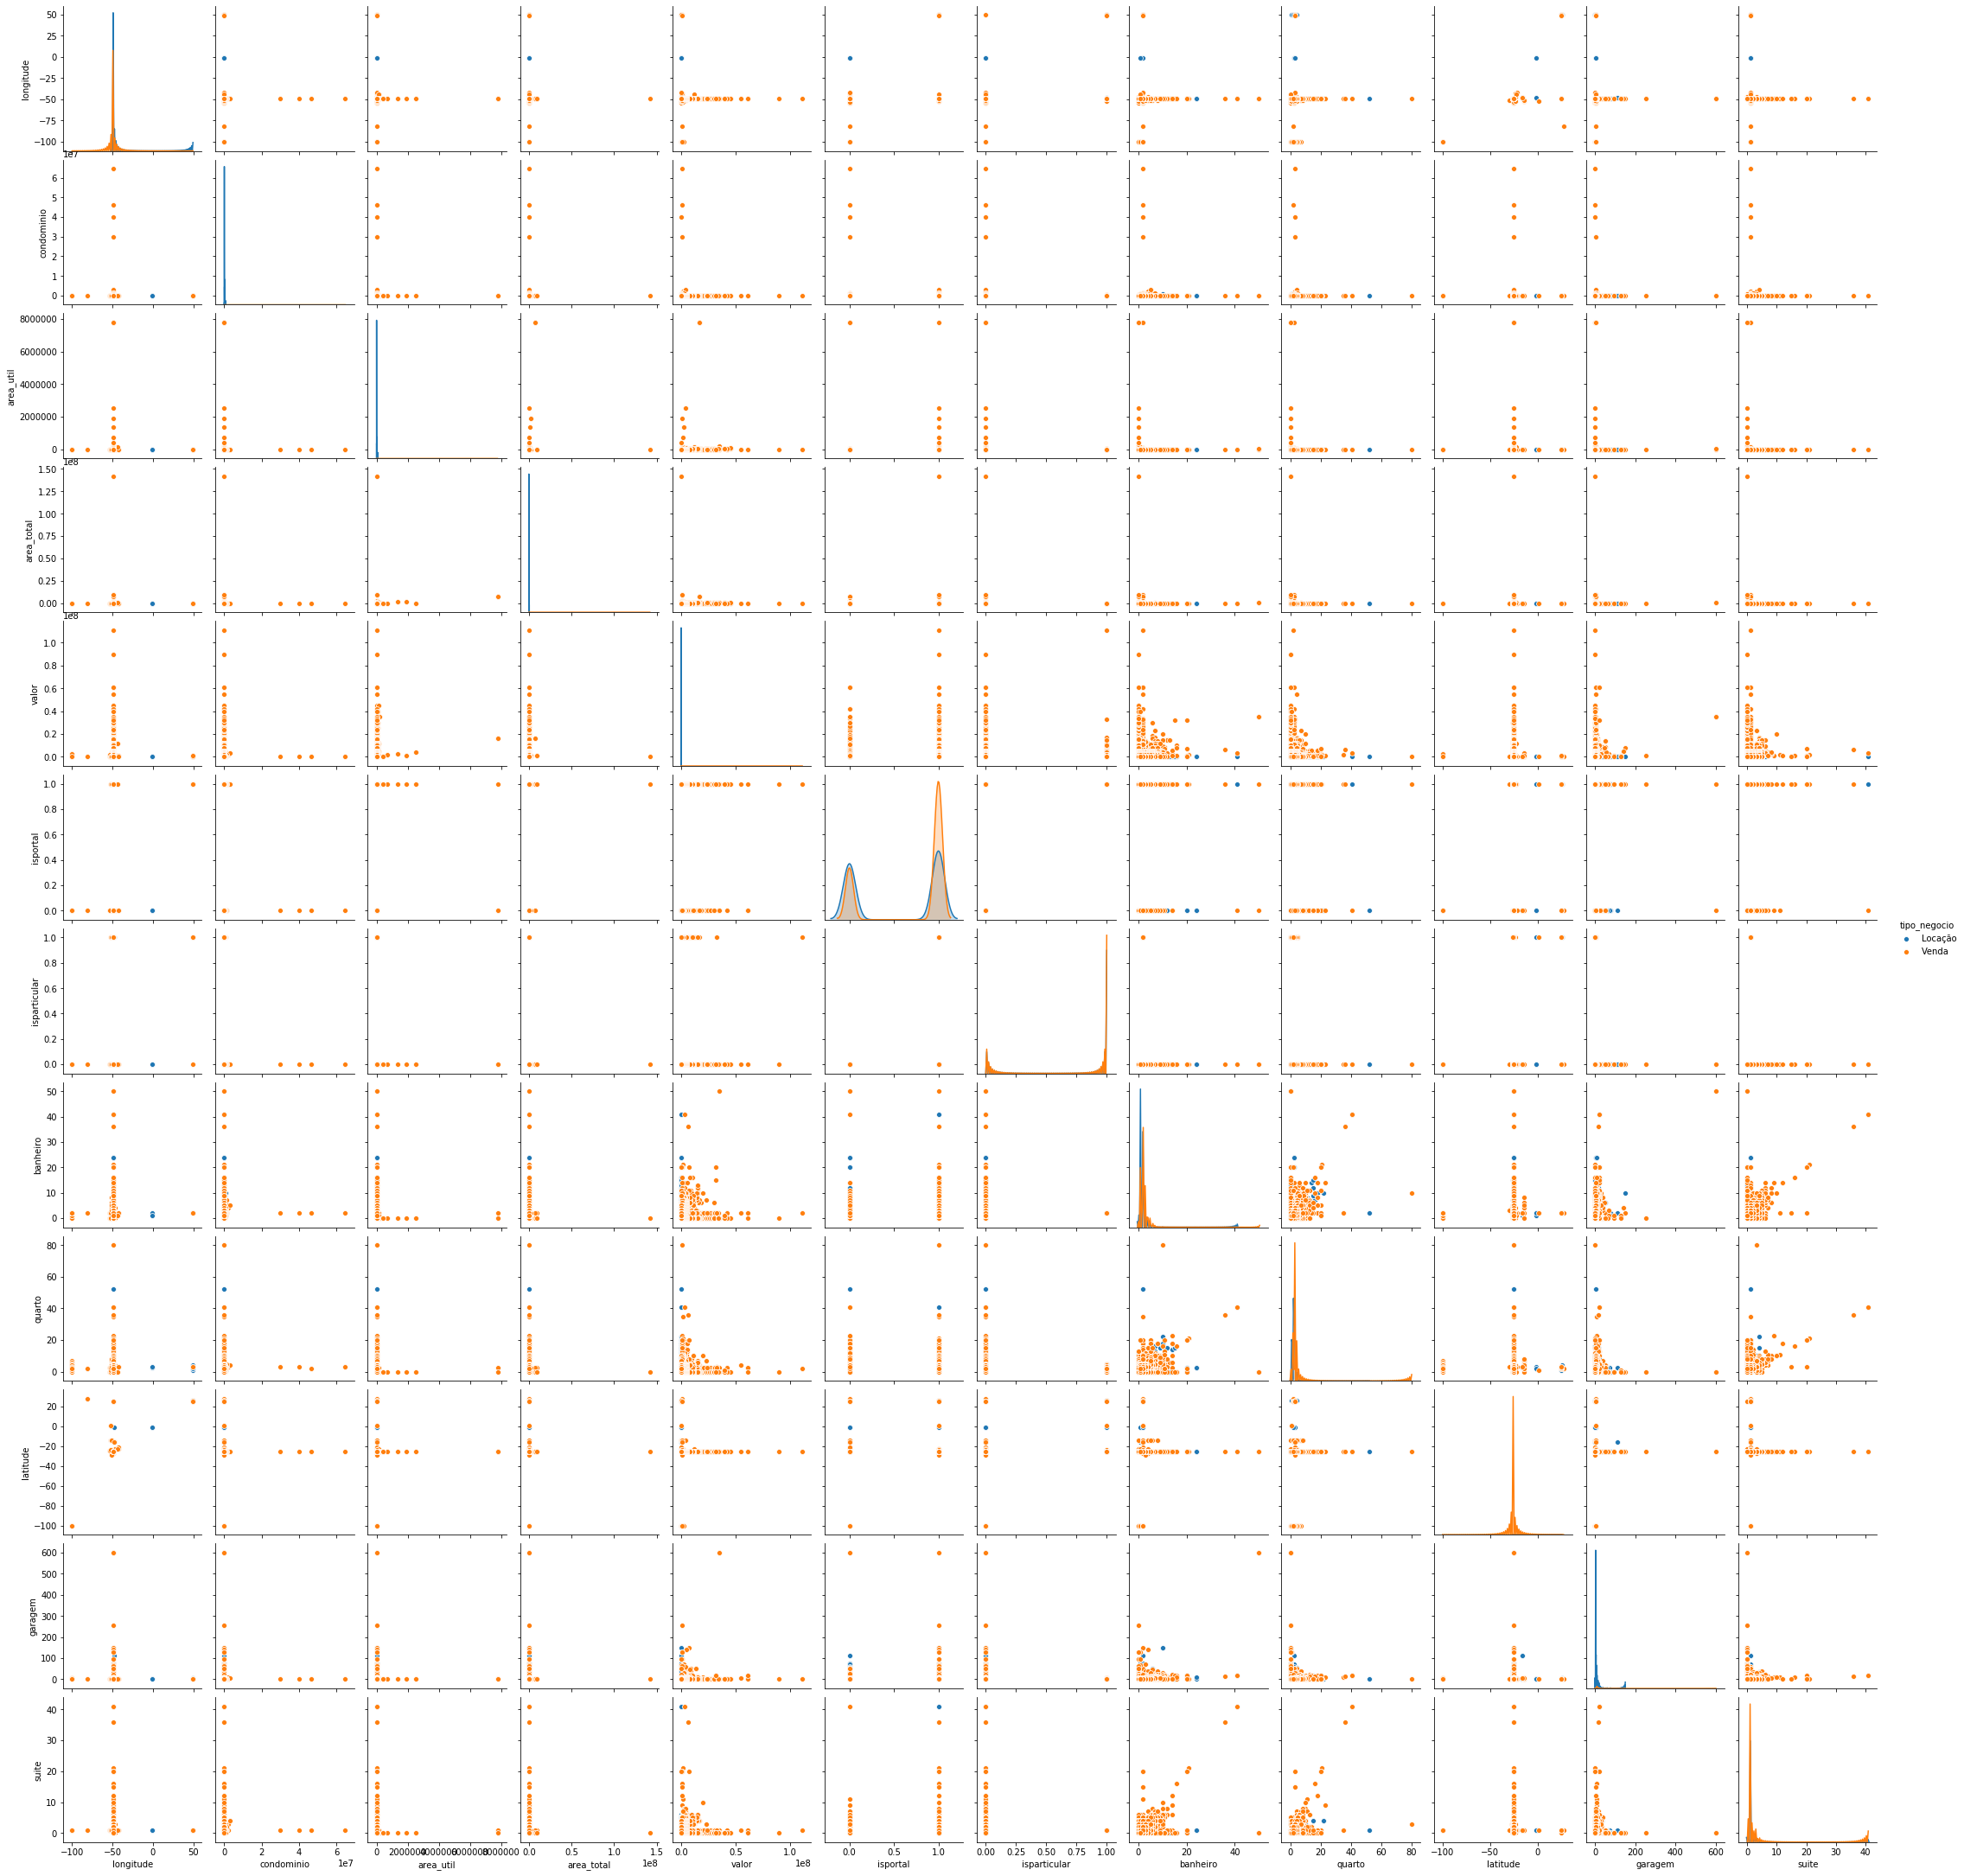

In [527]:
plt.figure(figsize=(12,12))
sns.pairplot(data=essentials,hue='tipo_negocio')

# Outlier Analysis

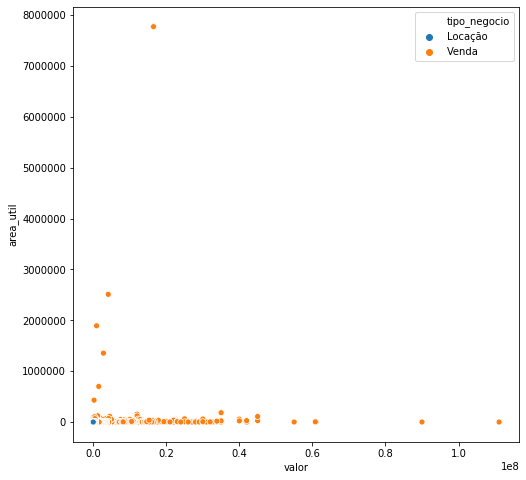

In [528]:
plt.figure(figsize=(8,8))
ax = sns.scatterplot(x='valor',y='area_util',hue='tipo_negocio',data=essentials)

Defining function for detection of outliers. We choose the Inter Quantile Range for it, which is the distance between the points and the median

In [0]:
def find_outlier(df,col):
  q3 = df[col].quantile(q=0.75)
  q2 = df[col].quantile(q=0.5)
  q1 = df[col].quantile(q=0.25)
  iqr = q3-q1
  return np.abs(df[col]-q2)>1.5*iqr

I choose to evaluate outliers analysis using only information about latitude and longitude, due to the fact of the location of every property be in the city of Curitiba-PR. 

Other columns could also be used, but it can be a more delicate task. For example, a propertie with ```banheiro```>50 may be treated as outlier, even though it is possible to be a correct value. This analysis would be better made with help of a real estate professional.

## Outlier identification and fix

In [530]:
 essentials[(find_outlier(essentials,'latitude'))].sort_values(by='latitude')

,longitude,condominio,area_util,area_total,valor,isportal,isparticular,banheiro,tipo_negocio,quarto,latitude,garagem,codigo,anunciante.nome,suite
33221,-100.000000,2777.111603,1640.000000,1640.000000,2350000.0,False,False,2.05943,Venda,2.407888,-100.000000,1.882187,9470,Cibraco,0.976904
33322,-100.000000,2777.111603,91.560000,163.070000,539000.0,False,False,2.05943,Venda,2.000000,-100.000000,3.000000,8011,Cibraco,0.976904
32996,-100.000000,2777.111603,198.000000,198.000000,1100000.0,False,False,2.05943,Venda,2.000000,-100.000000,4.000000,9468,Cibraco,0.976904
32990,-100.000000,2777.111603,161.600000,218.270000,830000.0,False,False,2.05943,Venda,2.000000,-100.000000,4.000000,9493,Cibraco,0.976904
32887,-100.000000,2777.111603,214.390000,214.390000,650000.0,False,False,2.05943,Venda,3.000000,-100.000000,5.000000,9500,Cibraco,0.976904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43823,49.310584,130.000000,467.048829,2256.762395,800.0,True,True,2.05943,Locação,1.000000,25.509327,1.000000,558976431,Particular - OLX,0.976904
57498,49.267406,2777.111603,467.048829,2256.762395,295000.0,True,True,2.05943,Venda,3.000000,25.511938,2.000000,539698164,Particular - OLX,0.976904
37517,49.246311,2777.111603,467.048829,2256.762395,3000.0,True,True,2.05943,Locação,4.000000,25.537891,5.000000,550678689,Particular - OLX,0.976904
58931,49.251675,0.000000,52.000000,2256.762395,850.0,True,True,2.05943,Locação,2.000000,25.555411,1.000000,545398630,Particular - OLX,0.976904


In [531]:
essentials.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143491 entries, 0 to 149967
Data columns (total 15 columns):
longitude          143491 non-null float64
condominio         143491 non-null float64
area_util          143491 non-null float64
area_total         143491 non-null float64
valor              143491 non-null float64
isportal           143491 non-null bool
isparticular       143491 non-null bool
banheiro           143491 non-null float64
tipo_negocio       143491 non-null object
quarto             143491 non-null float64
latitude           143491 non-null float64
garagem            143491 non-null float64
codigo             63445 non-null object
anunciante.nome    141983 non-null object
suite              143491 non-null float64
dtypes: bool(2), float64(10), object(3)
memory usage: 20.6+ MB


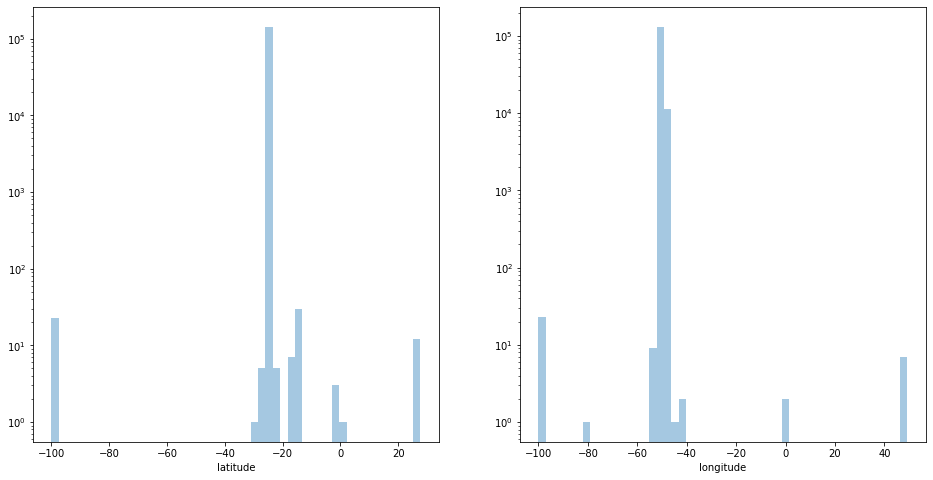

In [532]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
ax = sns.distplot(essentials['latitude'],kde=False)
ax.set_yscale('log')
plt.subplot(1,2,2)
binwidth = 2.5
ax = sns.distplot(essentials['longitude'],kde=False)
ax.set_yscale('log')

1. Logarithmic scale was used for better visualization of data. 
2. Latitude graph with bin width = 2.5. 
3. Data out of the range -27.5 < ```latitude ``` < -22.5 are treated as outliers.
4. Data out of the range -60 < ```longitude```< -40 are also treated as outliers.
5. Data within 22.5 < ```latitude ``` < 27.5 is probably lacking a minus sign. The same possibly happens with data within  40 < ```longitude```< 60. For that, I am just changing sign of these values.
6. I am replacing remaining outliers by average val
ue of the corresponding column.

Creating dataframes with latitude and longitude outliers:



In [0]:
latitude_outliers = essentials[(essentials['latitude']>-22.5) | (essentials['latitude']<-27.5)]
longitude_outliers = essentials[(essentials['longitude']>-40) | (essentials['latitude']<-60)]

In [534]:
latitude_outliers.head()

,longitude,condominio,area_util,area_total,valor,isportal,isparticular,banheiro,tipo_negocio,quarto,latitude,garagem,codigo,anunciante.nome,suite
5653,-50.713421,2777.111603,110.37,232.96,920000.0,False,False,4.0,Venda,4.0,-13.901082,2.0,62261-J8,Baggio,0.976904
5662,-50.713421,2777.111603,335.66,472.69,1980000.0,False,False,8.0,Venda,7.0,-13.901082,4.0,62227-J8,Baggio,0.976904
5666,-50.713421,2777.111603,426.90,579.50,2590000.0,False,False,6.0,Venda,8.0,-13.901082,4.0,62259-J8,Baggio,0.976904
6013,-50.713421,2777.111603,596.00,596.00,3650000.0,False,False,8.0,Venda,7.0,-13.901082,5.0,61817-J8,Baggio,0.976904
6037,-50.713421,2777.111603,167.78,244.37,870000.0,False,False,4.0,Venda,5.0,-13.901082,2.0,61787-J8,Baggio,0.976904


In [535]:
longitude_outliers.head()

,longitude,condominio,area_util,area_total,valor,isportal,isparticular,banheiro,tipo_negocio,quarto,latitude,garagem,codigo,anunciante.nome,suite
7750,-100.0,2777.111603,30.43,39.14,175000.0,False,False,0.0,Venda,1.0,-100.0,0.0,8363-HABITEC,Baggio,0.976904
8306,-100.0,2777.111603,216.00,216.00,592000.0,False,False,0.0,Venda,3.0,-100.0,4.0,9604-HABITEC,Baggio,0.976904
8376,-100.0,2777.111603,133.58,133.56,550000.0,False,False,1.0,Venda,3.0,-100.0,5.0,8964-HABITEC,Baggio,0.976904
9887,-100.0,2777.111603,1640.00,1640.00,2350000.0,False,False,0.0,Venda,0.0,-100.0,0.0,9470-HABITEC,Baggio,0.976904
9888,-100.0,2777.111603,198.00,198.00,1100000.0,False,False,2.0,Venda,7.0,-100.0,2.0,9468-HABITEC,Baggio,0.976904


Collecting indexes for data needing a change of sign

In [0]:
idx_invlatout = latitude_outliers[(latitude_outliers['latitude']>22.5) & (latitude_outliers['latitude']<27.5)].index.values
idx_invlongout = longitude_outliers[(longitude_outliers['longitude']>40) & (longitude_outliers['longitude']<60)].index.values

In [537]:
print(idx_invlatout,idx_invlongout)

[19905 32186 34103 37517 39735 43823 51925 56497 57498 58931 62249] [37517 43823 51925 56497 57498 58931 62249]


In [0]:
for row in idx_invlatout:
  essentials.loc[row,'latitude'] *= -1
for row in idx_invlongout:
  essentials.loc[row,'longitude'] *= -1

In [539]:
essentials[essentials['latitude']>22.5]


,longitude,condominio,area_util,area_total,valor,isportal,isparticular,banheiro,tipo_negocio,quarto,latitude,garagem,codigo,anunciante.nome,suite
11038,-81.515754,480.0,467.048829,150.77,595000.0,False,False,2.05943,Venda,2.0,27.664827,2.0,60626,J8 Imóveis,0.976904


In [540]:
essentials[essentials['longitude']>40]

,longitude,condominio,area_util,area_total,valor,isportal,isparticular,banheiro,tipo_negocio,quarto,latitude,garagem,codigo,anunciante.nome,suite


## Outlier replacement

Redefining dataframes with outliers of latitude and longitude

In [0]:
latitude_outliers = essentials[(essentials['latitude']>-22.5) | (essentials['latitude']<-27.5)]
longitude_outliers = essentials[(essentials['longitude']>-40) | (essentials['longitude']<-60)]

In [542]:
latitude_outliers['latitude'].value_counts()

-100.000000    23
-13.901082     16
-13.901082     10
-15.778977      7
-14.235004      4
-1.000000       2
-21.160044      1
-29.225625      1
 0.901992       1
-1.365424       1
 27.664827      1
Name: latitude, dtype: int64

In [543]:
longitude_outliers['longitude'].value_counts()

-100.000000    23
-1.000000       2
-81.515754      1
Name: longitude, dtype: int64

Collecting indexes of outliers:

In [544]:
idx2_invlatout = latitude_outliers[(latitude_outliers['latitude']<22.5) | (latitude_outliers['latitude']>27.5)].index.values
idx2_invlatout


array([  5653,   5662,   5666,   6013,   6037,   6083,   6970,   7050,
         7395,   7750,   8306,   8376,   8604,   8616,   9210,   9329,
         9887,   9888,   9895,   9901,   9920,  10617,  10668,  10672,
        10680,  10803,  10807,  11038,  11703,  13517,  15578,  15993,
        20248,  20499,  21328,  21335,  21788,  21958,  22157,  22180,
        23490,  23515,  23645,  23891,  23983,  24001,  24060,  24958,
        32795,  32841,  32887,  32990,  32996,  33217,  33221,  33322,
        36882,  36884,  36888,  37886,  37891,  39831,  40341,  50616,
        51158,  51390, 141196])

In [545]:

idx2_invlongout = longitude_outliers[(longitude_outliers['longitude']<40) | (latitude_outliers['latitude']>60)].index.values
idx2_invlongout

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


array([ 7750,  8306,  8376,  9887,  9888,  9895,  9920, 10668, 10672,
       10680, 11038, 15578, 15993, 23645, 23891, 23983, 24001, 24060,
       24958, 32795, 32841, 32887, 32990, 32996, 33221, 33322])

Evaluating averages for data with and without outliers:

In [546]:
# Testando médias de latitude e longitude calculadas com e sem outliers
print('latitude:','\n',essentials['latitude'].mean(),
essentials['latitude'].drop(idx2_invlatout,axis=0).mean(),'\n',
'longitude:','\n',essentials['longitude'].mean(),
essentials['longitude'].drop(idx2_invlongout,axis=0).mean())

latitude: 
 -25.458070709323188 -25.45006427720255 
 longitude: 
 -49.28829485778938 -49.2806134017743


Replacing outliers by average of the column obtained without the outliers:

In [0]:
for row in idx2_invlatout:
  essentials.loc[row,'latitude'] = essentials['latitude'].drop(idx2_invlatout,axis=0).mean()
for row in idx2_invlongout:
  essentials.loc[row,'longitude'] = essentials['longitude'].drop(idx2_invlongout,axis=0).mean()

In [548]:
print(essentials['latitude'].loc[idx2_invlatout],
essentials['longitude'].loc[idx2_invlongout])

5653     -25.450064
5662     -25.450064
5666     -25.450064
6013     -25.450064
6037     -25.450064
            ...    
40341    -25.450064
50616    -25.450064
51158    -25.450064
51390    -25.450064
141196   -25.450064
Name: latitude, Length: 67, dtype: float64 7750    -49.280613
8306    -49.280613
8376    -49.280613
9887    -49.280613
9888    -49.280613
9895    -49.280613
9920    -49.280613
10668   -49.280613
10672   -49.280613
10680   -49.280613
11038   -49.280613
15578   -49.280613
15993   -49.280613
23645   -49.280613
23891   -49.280613
23983   -49.280613
24001   -49.280613
24060   -49.280613
24958   -49.280613
32795   -49.280613
32841   -49.280613
32887   -49.280613
32990   -49.280613
32996   -49.280613
33221   -49.280613
33322   -49.280613
Name: longitude, dtype: float64


# Principal Component Analysis

The Principal Component Analysis evaluates a linear combination of the original components to create a reduced number of components that describes the variances of the data. Only float and boolean columns can be used.

Scaling components for putting all of them in a same scale:

In [549]:
scaler = StandardScaler()
scaler.fit(nonobj_essentials)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [0]:
scaled_nonobj_essentials = scaler.transform(nonobj_essentials)

Finding the two-dimensional that best describes the data

In [0]:
pca = PCA(n_components=2)

In [552]:
pca.fit(scaled_nonobj_essentials)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Projecting data onto the plane

In [0]:
nonobj_essentials_pc = pca.transform(scaled_nonobj_essentials)

In [554]:
nonobj_essentials_pc.shape


(143491, 2)

Text(0, 0.5, 'Second Principal Component')

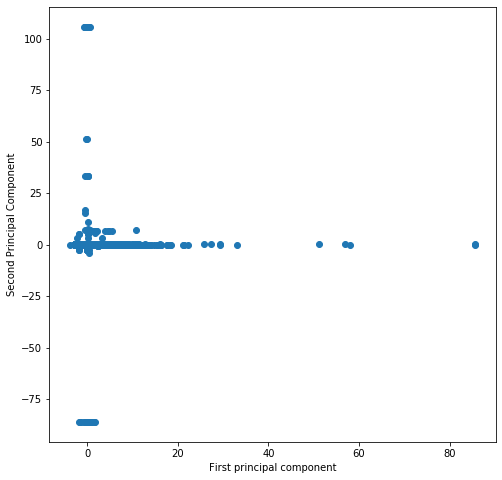

In [555]:
plt.figure(figsize=(8,8))
plt.scatter(nonobj_essentials_pc[:,0],nonobj_essentials_pc[:,1])
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

## Analyzing components

Now I try to figure out the meaning of the two components given by the two directions in the plane

In [556]:
pca.components_

array([[-1.30918518e-03,  1.90609249e-03,  8.68095770e-03,
        -3.16651204e-03,  3.18494558e-01, -8.73932879e-02,
        -1.09159787e-02,  5.48900010e-01,  4.65182493e-01,
         3.51451867e-03,  3.06763118e-01,  5.28121012e-01],
       [ 7.06616685e-01, -4.68554960e-04, -3.35434712e-04,
        -7.52868414e-05, -2.96336318e-03,  2.99394673e-02,
         2.70316125e-02,  5.78737641e-03, -1.39805979e-03,
         7.06414106e-01,  1.89762703e-04, -5.36235178e-04]])

In [557]:
essentials.head()

,longitude,condominio,area_util,area_total,valor,isportal,isparticular,banheiro,tipo_negocio,quarto,latitude,garagem,codigo,anunciante.nome,suite
0,-49.278522,590.000000,131.000000,131.000000,1590.0,False,False,2.0,Locação,2.000000,-25.435591,1.000000,AP0145-GOMG,Rede Bee,0.976904
1,-49.280365,356.000000,36.000000,69.000000,1200.0,False,False,1.0,Locação,1.000000,-25.427486,1.000000,ST0027-GOMG,Rede Bee,0.976904
2,-49.349094,400.000000,467.048829,2256.762395,714200.0,False,False,3.0,Venda,3.000000,-25.453186,1.000000,CA0072-CST,Rede Bee,1.000000
3,-49.350033,620.000000,467.048829,2256.762395,1577800.0,False,False,5.0,Venda,4.000000,-25.406399,2.000000,CA0085-CST,Rede Bee,2.000000
4,-49.236857,2777.111603,23.000000,23.000000,650.0,False,False,1.0,Locação,2.407888,-25.503107,1.882187,LO0027-OTI,Rede Bee,0.976904


In [0]:
comps = pd.DataFrame(pca.components_,columns=essentials.drop(labels=['tipo_negocio','codigo','anunciante.nome'],axis=1).columns.values)

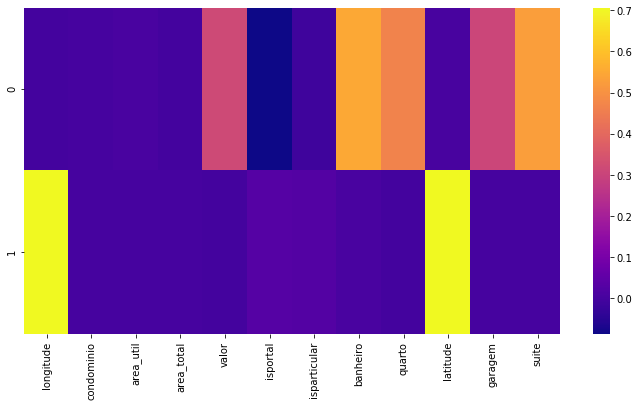

In [559]:
plt.figure(figsize=(12,6))
sns.heatmap(comps,cmap='plasma')

1. The first component has bigger weights for particular informations of the property, such as ```valor```, ```banheiro```, ```quarto```,```garagem``` and  ```suite```.
2. The second component represents the location, with greater weights for ```latitude``` and ```longitude```.